<a href="https://colab.research.google.com/github/aclightbody/MIoT_Project/blob/main/Project_ESP32_MPU6050_DMP6/Scripts/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training is much faster using GPU acceleration. Before you proceed, ensure you are using a GPU runtime by going to **Runtime -> Change runtime type** and selecting **GPU**. Training will take around 5 minutes on a GPU runtime.

In [1]:
# Clone repository from GitHub
!git clone https://github.com/aclightbody/MIoT_Project.git

fatal: destination path 'MIoT_Project' already exists and is not an empty directory.


In [2]:
import csv
import pandas
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import StratifiedKFold

# https://stackoverflow.com/questions/55424906/building-svm-with-tensorflows-linearclassifier-and-pandas-dataframes
# https://aiplanet.com/notebooks/2418/binthamza/svm-classification-with-tfkeras-model
# https://stackoverflow.com/questions/55424906/building-svm-with-tensorflows-linearclassifier-and-pandas-dataframes
# https://www.kaggle.com/code/shadesh/svm-classification-using-tensorflow-and-keras

cwd = os.getcwd()
print(cwd)

path = '/content/MIoT_Project/Project_ESP32_MPU6050_DMP6/Data'
dataDrop = pandas.read_csv(path + "/FeatureExtractDrop.csv").values
dataWalk = pandas.read_csv(path + "/FeatureExtractWalk.csv").values

/content


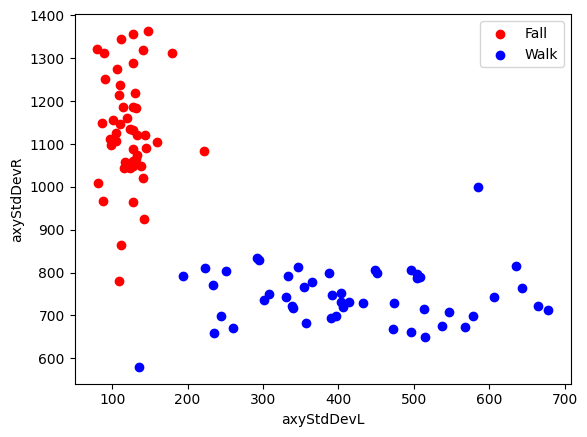

In [3]:
# Features
x = dataDrop[:, 1:]
x = numpy.append(x,dataWalk[:,1:], axis=0)

# Labels
y = dataDrop[:, 0]
y = numpy.append(y,dataWalk[:,0], axis=0)
y = numpy.where(y==1, y, 0) # Converting -1 to 0, to have 0 and 1 labels. Normally would have binary labels as -1 and +1 for hinge loss, but tf.keras.losses.Hinge() expects 0 and +1. If doing custom hinge loss function, then labels would be -1 and +1 e.g. https://stackoverflow.com/questions/55424906/building-svm-with-tensorflows-linearclassifier-and-pandas-dataframes

plt.scatter(dataDrop[:,1], dataDrop[:,2], c='red', label='Fall')
plt.scatter(dataWalk[:,1], dataWalk[:,2], c='blue', label='Walk')
plt.xlabel("axyStdDevL")
plt.ylabel("axyStdDevR")
plt.legend(loc="upper right")
plt.show()

In [4]:
def get_model():
    #Linear SVM model
    model = tf.keras.Sequential()
    # Metric: is a function to assess model performance. Similar to loss functions, except that the results from evaluating a metric are not used when training the model. Note that you may use any loss function as a metric.
    # Optimizer: adam is a commonly used one. Learning rate: step size when adjusting paramters in model (usually 0.001 to 0.1). Larger learning rate reduces iterations but reduces accuracy, smaller rate gives higher accuracy and more iterations. https://stackoverflow.com/questions/59737875/keras-change-learning-rate
    # Dense layer of 1 means that this layer has one neuron (unit). Since only one layer (output layer) is being added with one neuron, it's linear.
    # Activation function: mathematical function applied to the neuron output in a neural layer. These are used to introduce non-linearity in a neural network. Linear (pass through): input unmodified. https://keras.io/api/layers/activations/.
    # Kernel regularizer: Typical values for the regularisation parameters are 1 to 10, 10 being default. https://keras.io/api/layers/regularizers/. L1 and L2 regularizers have default of 0.01. The L2 regularization penalty is computed as: loss = l2 * reduce_sum(square(x)).Kernel regularizer tries to reduce the weights (excluding bias). https://stats.stackexchange.com/questions/383310/what-is-the-difference-between-kernel-bias-and-activity-regulizers-and-when-t
    # Loss: Hinge loss is equivalent to slack variable. Custom loss function used for hinge loss https://keras.io/api/losses/. https://keras.io/api/losses/hinge_losses/.
    # Kernel: linear, polynomial, guassian, sigmoid, etc
    optmzr = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.add(tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(1)))
    model.compile(optimizer=optmzr, loss=tf.keras.losses.Hinge(), metrics=["accuracy"])
    return model

In [5]:
# https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=10, shuffle=True)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(x, y)):
    print ("Training on fold " + str(index+1) + "/10...")
    # Generate batches from indices
    xtrain, xval = x[train_indices], x[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]
    # Clear model, and create it
    model = None
    model = get_model()

    # Debug message I guess
    # print "Training new iteration on " + str(xtrain.shape[0]) + " training samples, " + str(xval.shape[0]) + " validation samples, this may be a while..."

    history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=100, verbose=False)
    accuracy_history = history.history['accuracy']
    val_accuracy_history = history.history['val_accuracy']
    print("Last training accuracy: " + str(accuracy_history[-1]) + ", last validation accuracy: " + str(val_accuracy_history[-1]))

# Need to average the accuracy scores


Training on fold 1/10...
Last training accuracy: 0.8666666746139526, last validation accuracy: 1.0
Training on fold 2/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 3/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 4/10...
Last training accuracy: 0.9888888597488403, last validation accuracy: 1.0
Training on fold 5/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 6/10...
Last training accuracy: 0.9777777791023254, last validation accuracy: 0.8999999761581421
Training on fold 7/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 8/10...
Last training accuracy: 0.9777777791023254, last validation accuracy: 1.0
Training on fold 9/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 10/10...
Last training accuracy: 0.5, last validation accuracy: 0.8999999761581421


In [6]:
# model = None
# model = get_model()

In [7]:
# batch_size: Number of samples per gradient update. If unspecified, batch_size will default to 32. The batch size is the number of training examples that you use to perform one step of stochastic gradient descent (SGD). https://stackoverflow.com/questions/61029052/what-is-the-batchsize-in-tensorflows-model-fit-function
# history = model.fit(x, y, epochs=50, verbose=False, batch_size=32)
print("Finished training the model")
model.summary()

Finished training the model


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11 (48.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8 (36.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
tf.Tensor(
[[5 0]
 [0 5]], shape=(2, 2), dtype=int32)


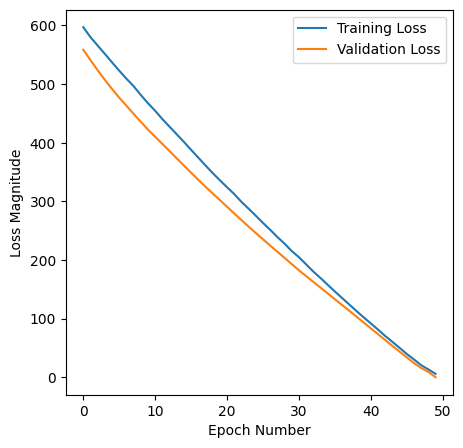

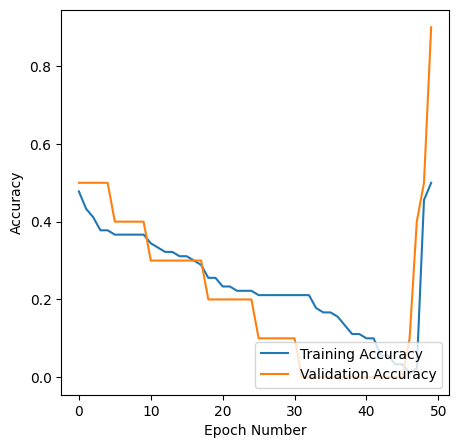

In [8]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5, 5))
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc="upper right")

plt.figure(figsize=(5, 5))
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc="lower right")

# pred = numpy.argmax(model.predict(xval), axis=1)
pred = numpy.where(model.predict(xval) > 0, 1, 0) # Binary class prediction, if prediction -ve class is 0, +ve prediction class is 1. https://stackoverflow.com/questions/68776790/model-predict-classes-is-deprecated-what-to-use-instead
confusion = tf.math.confusion_matrix(labels=tf.constant(yval), predictions=tf.constant(pred), num_classes=2)
print(confusion)

# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# loss, acc = model.evaluate(test_data)
# print("Loss {}, Accuracy {}".format(loss, acc))
# pred = np.argmax(model.predict(test_data), axis=1)
# confusion = tf.math.confusion_matrix(labels=tf.constant(test_labels), predictions=tf.constant(pred), num_classes=4)
# print(confusion)


In [9]:
# print(f' W: {model.weights}')
w = model.get_weights()[0] # weight vector w0, w1
b = model.get_weights()[1] # bias, b

# Same as above
print(model.layers[0].kernel.numpy()) # Weight vector
print(model.layers[0].bias.numpy()) # Bias

# Hyperplane
# w.x + b = 0
# w0*x0 + w1*x1 + b = 0
# y = mx + c --> x1 = -(w0/w1)*x0 - b/w1
# https://vitalitylearning.medium.com/support-vector-machines-with-tensorflow-4fb345f01bca
m = - w[0]/w[1] # gradient
c = - b[0]/w[1] # constant

xSep          = [x[0] for x in x]
ySep          = [m * x + c for x in xSep]

[[-0.01452695]
 [ 0.00212553]]
[0.96780807]


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

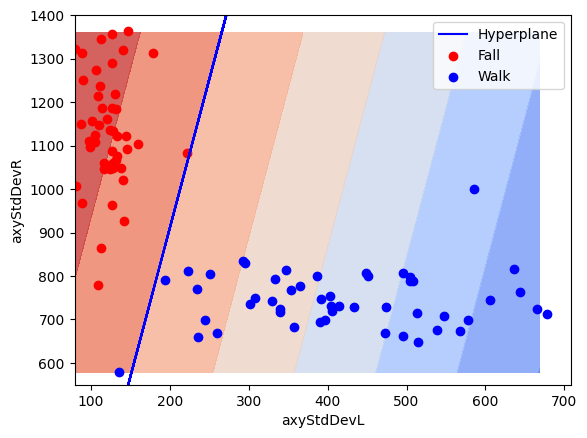

In [10]:
# prediction = model.predict_generator(test, verbose=1)
# plot_decision_regions(x, y, clf=model, legend=2) # Another function to

x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, 10),numpy.arange(y_min, y_max, 10)) # Had to put mesh grid to 1 or above, since axes are on the order of 100
Z = model.predict(numpy.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Set1)
# plt.plot(numpy.reshape(xSep, (len(xSep), 1)), numpy.reshape(ySep, (len(ySep), 1)), 'b-', label='Dividing line')
plt.plot(xSep, ySep, 'b-', label='Hyperplane')
plt.scatter(dataDrop[:,1], dataDrop[:,2], c='red', label='Fall')
plt.scatter(dataWalk[:,1], dataWalk[:,2], c='blue', label='Walk')
plt.xlabel("axyStdDevL")
plt.ylabel("axyStdDevR")
plt.legend(loc="upper right")
plt.ylim(550,1400)
plt.show